In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #plotting
import seaborn as sns
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
from tensorflow.python.keras.preprocessing.image_dataset import image_dataset_from_directory
import tensorflow as tf
import os

%matplotlib inline

In [2]:
# from PIL import Image
#
# def load_image( infilename ) :
#     img = Image.open( infilename )
#     img.load()
#     img = img.resize((227,227))
#     data = np.asarray( img, dtype="int32" )
#     return data / 255

In [3]:
def fill_test_dir(input_path, output_path, n_test_samples=1022):
    for emotion in os.listdir(input_path):
        inp = os.path.join(input_path, emotion)
        out = os.path.join(output_path, emotion)
        if len(os.listdir(out)) == 0:
            for ind, img in enumerate(os.listdir(inp)):
                src_path_to_img = os.path.join(inp, img)
                dst_path_to_img = os.path.join(out, img)
                # print(src_path_to_img, dst_path_to_img)
                os.replace(src_path_to_img, dst_path_to_img)
                if ind > n_test_samples:
                    break
    print("Test_spectrograms has been filled.")

In [4]:
path = "spectrograms/"
output_path = "test_spectrograms/"

fill_test_dir(output_path, path)

Test_spectrograms has been filled.


In [5]:
data_root = "spectrograms/"

import random
all_image_paths = [os.path.join(data_root, subdir, path) for subdir in os.listdir(data_root) for path in os.listdir(os.path.join(data_root, subdir))]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

29410

In [6]:
label_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
label_to_index = dict((name, index) for (index, name) in enumerate(label_names))
label_to_index

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
def get_label_from_path(path):
    return path.partition("/")[2].partition("/")[0]

all_image_labels = [label_to_index[get_label_from_path(path)]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 0, 0, 5, 4, 4, 2, 1, 3, 4]


In [8]:
img_path = all_image_paths[0]
img_path

'spectrograms/happy/3470242586107582775.png'

In [9]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01R\x00\x00...


In [10]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(220, 338, 4)
<dtype: 'uint8'>


In [11]:
# img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_tensor / 255
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(220, 338, 4)
0.0
1.0


In [12]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image /= 255  # normalize to [0,1] range
    return image

In [13]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

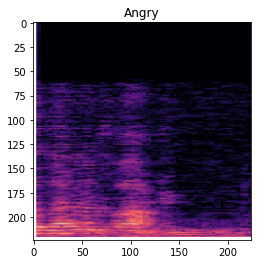

In [14]:
image_path = all_image_paths[1]
label = all_image_labels[1]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

### Let's build the dataset

In [15]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [16]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [30]:
vgg16 = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False)
vgg16.trainable = False

In [ ]:
image_batch, label_batch = next(iter(ds))

In [ ]:
feature_map_batch = vgg16(image_batch)
print(feature_map_batch.shape)

In [ ]:
model = tf.keras.Sequential([
  vgg16,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])